<a href="https://colab.research.google.com/github/RubyLau/HKUST/blob/main/Mahjong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mahjong Project

# Feature list 
1. Current on hand
2. Other discard
3. Other steal
4. Dora indicator
5. Own wind
6. Round wind
7. Richii player


# Word convention
- Stage : Turn of the game
- table : The data available on the table
- Player : The player for the specific data (Each player observes different information)
- Tile : Card
- Hand tile : Tile on their own hand
- game_info = first line of datafile (e.g. 东	0	['荒庄-0']		荒庄)
- score : score won by the player
- action : the action done by the player ('打牌', '摸牌', '补花', '补花后摸牌')




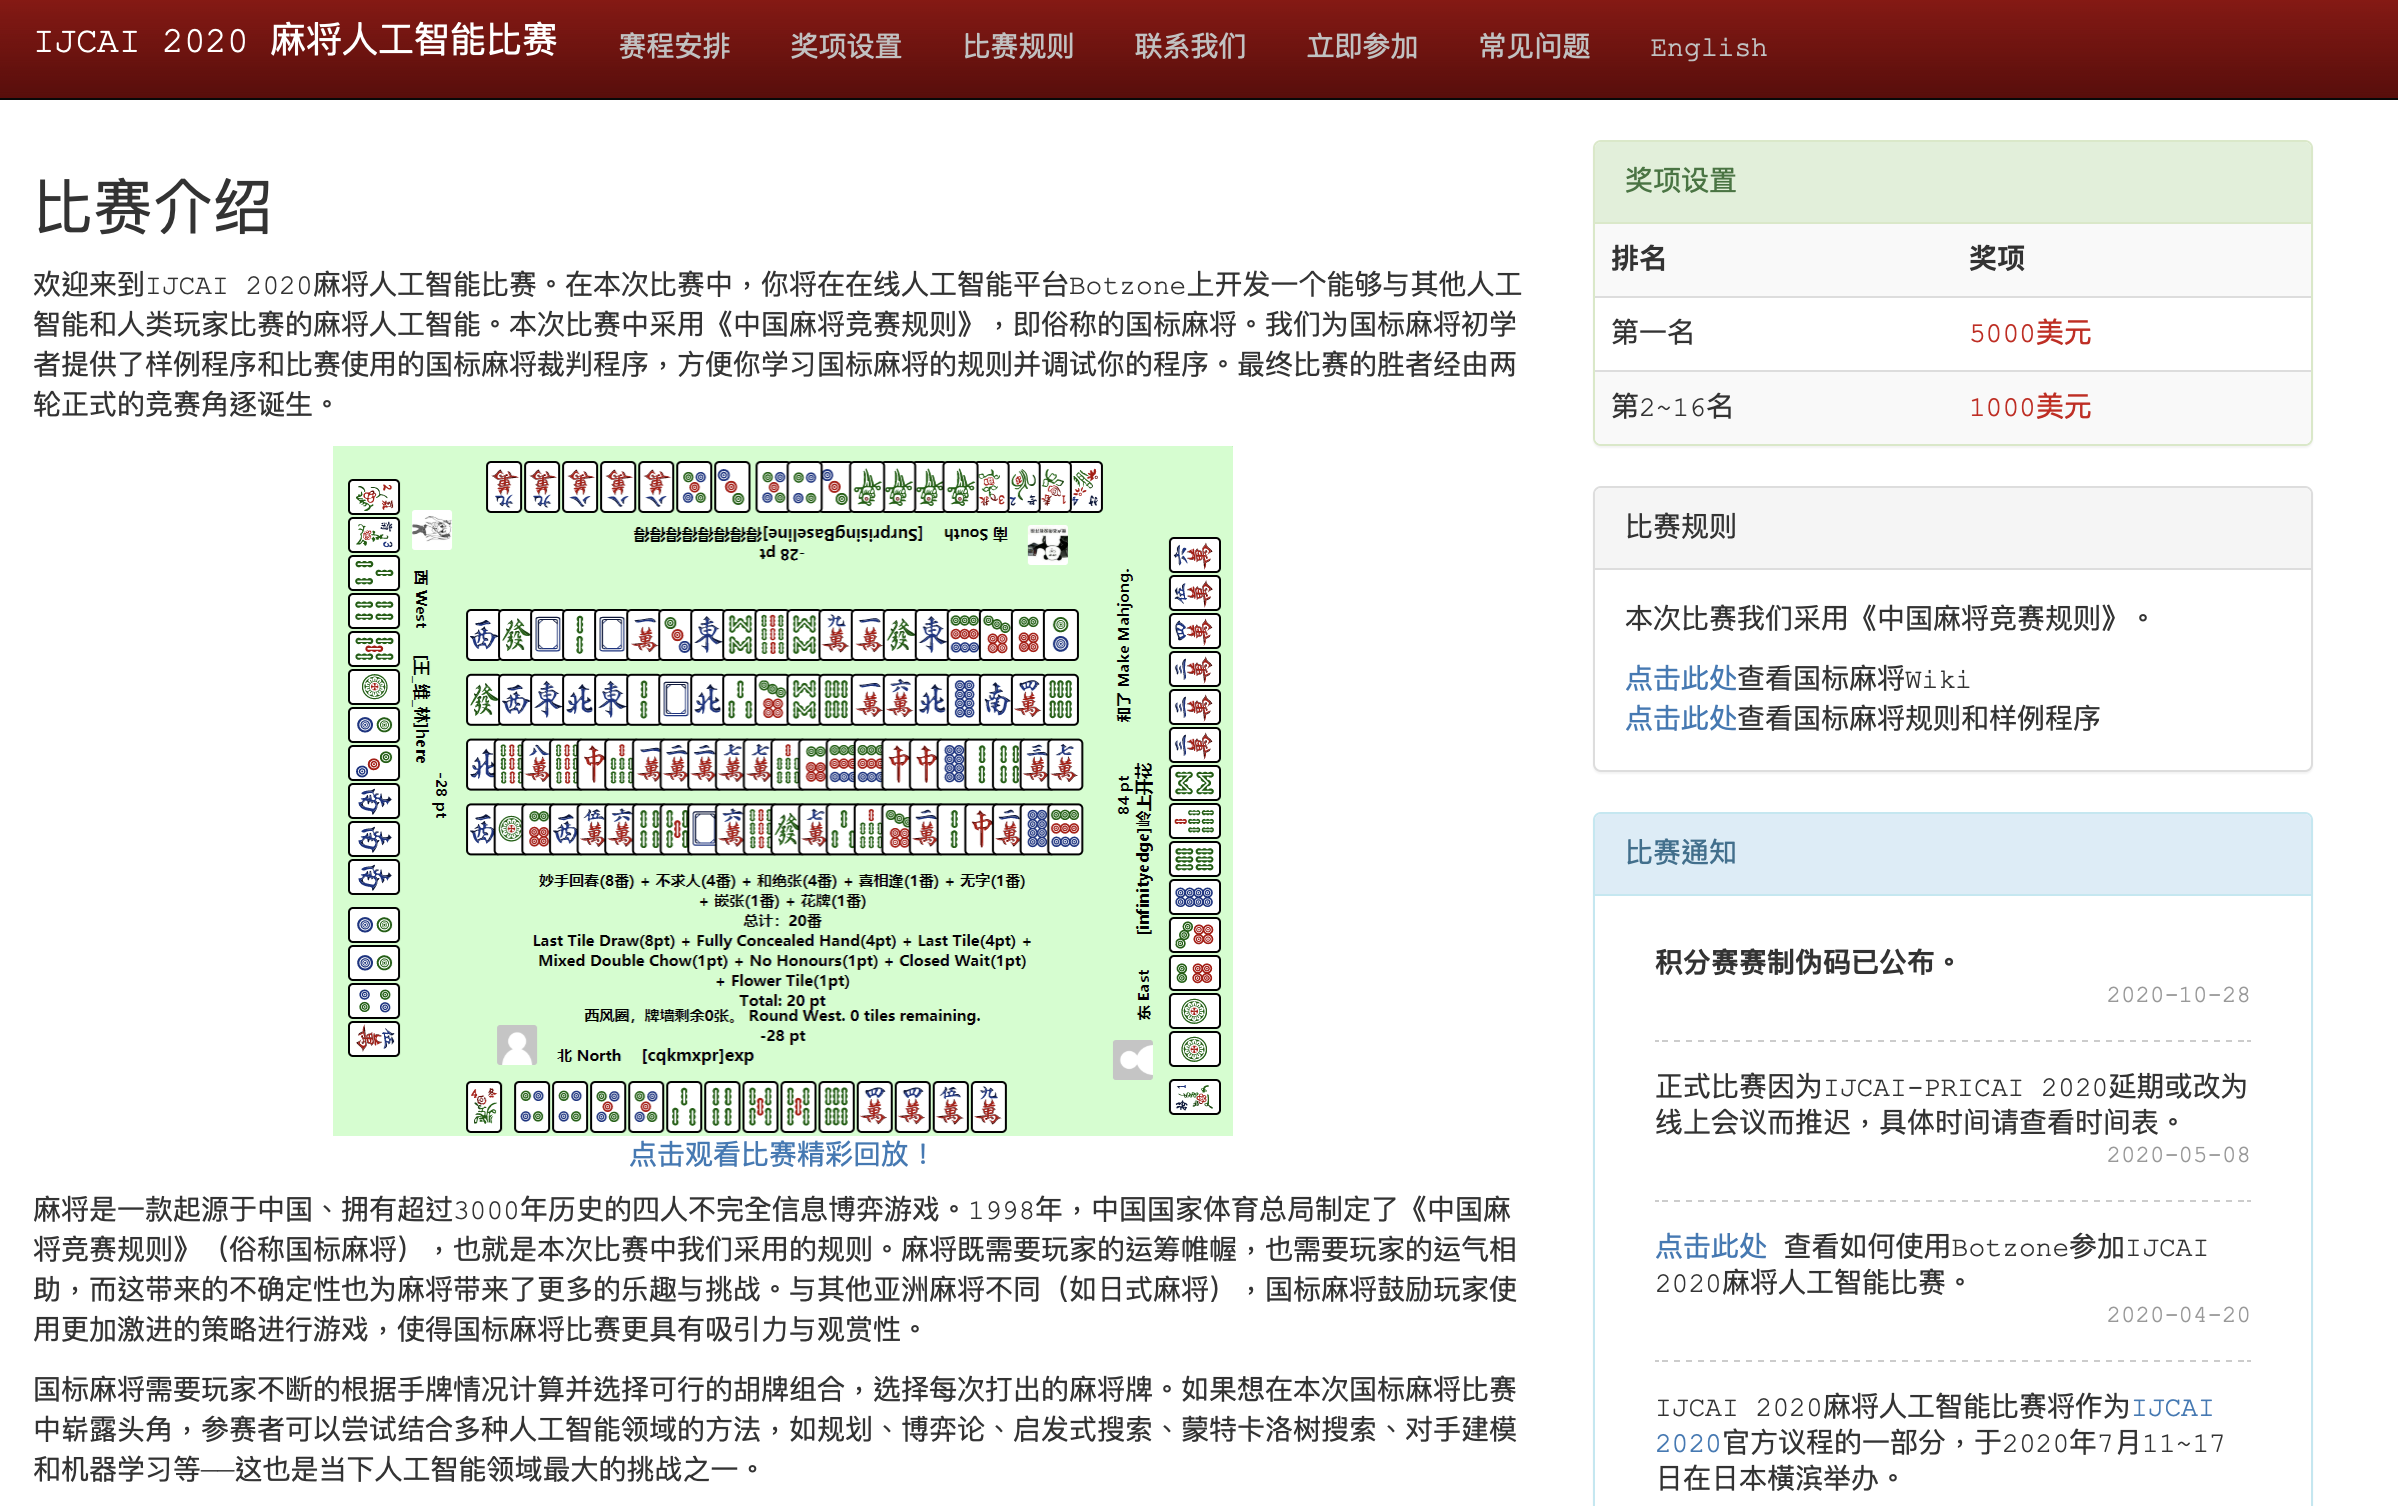


# Datset snapshot
东	0	['荒庄-0']		荒庄
0	['J2','B8','W5','T3','W8','B6','T5','T7','T1','T4','W4','T6','F3']	0
1	['B4','F2','F2','W2','W3','F2','B2','W4','W8','B8','T3','B6','B5']	2
2	['B7','B3','F2','B7','W3','W1','J2','W7','T1','J3','W5','T6','W9']	2
3	['B8','F1','T4','T2','F3','W6','J2','T1','T5','J3','B9','B1','B2','W4']	1
3	打牌	['F1']	
0	摸牌	['F1']	
0	打牌	['F1']	
1	摸牌	['B2']	
1	打牌	['T3']	
2	摸牌	['T6']	

# Data Preprocessing

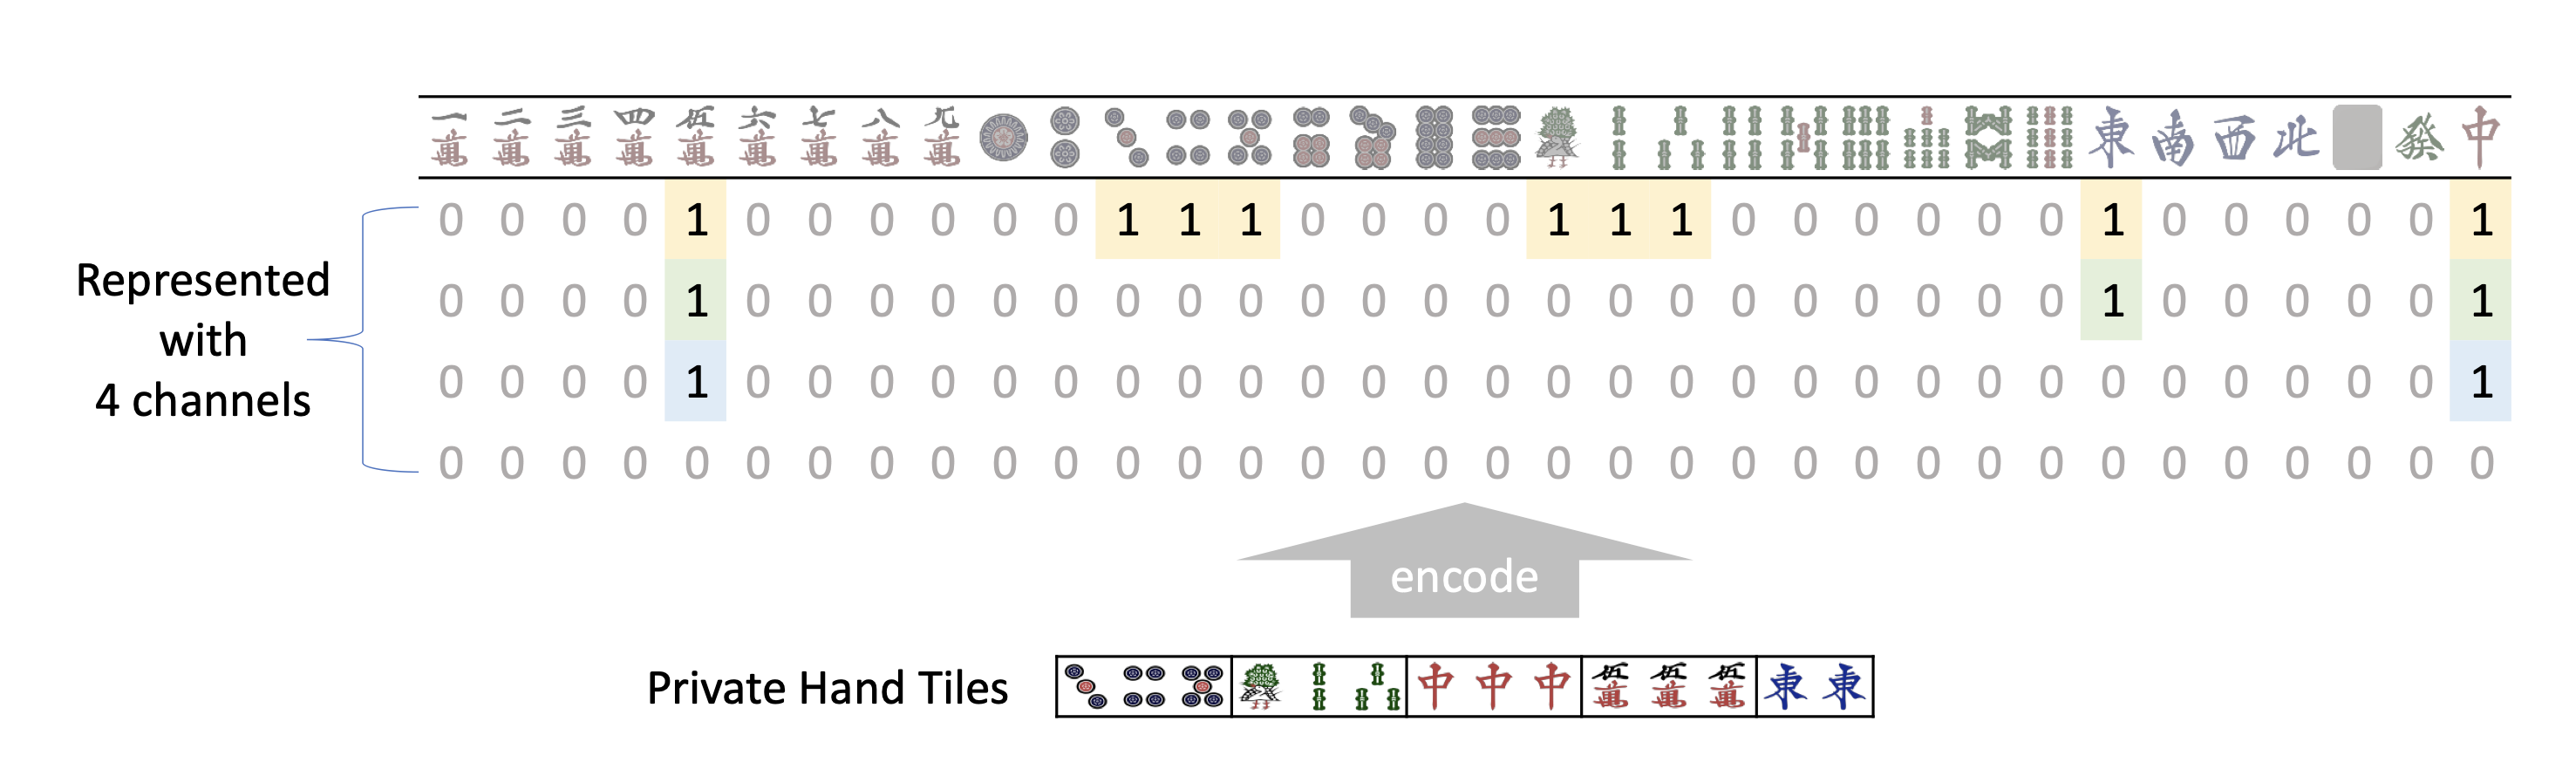

In [ ]:
import numpy as np
from collections import Counter

w_dict = {'W' + str(i+1): i for i in range(9)}
b_dict = {'B' + str(i+1): i+9 for i in range(9)}
t_dict = {'T' + str(i+1): i+18 for i in range(9)}
f_dict = {'F' + str(i+1): i+27 for i in range(4)}
j_dict = {'J' + str(i+1): i+31 for i in range(3)}
h_dict = {'H' + str(i+1): i+34 for i in range(9)}

def serialize(array):
    res=np.zeros((4,42),int)

    total_dict = {**w_dict, **b_dict,**t_dict,**f_dict,**j_dict,**h_dict}
    count = Counter(array)
    for i in count:
        index = total_dict[i]
        nums = count[i]
        for j in range(nums):
            res[j][index] = 1
    return np.expand_dims(np.array(res), axis = 0)

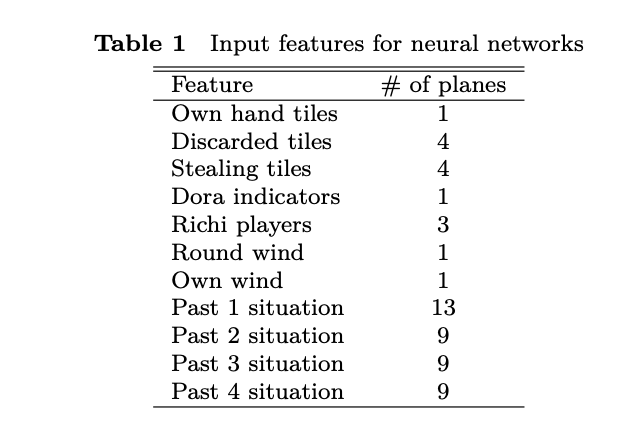

* Dora and Richi only exist in Richi Mahjong
* Wind information still to be confirm with dataset provider

In [ ]:
import ast
from collections import deque

f = open("2017-01-01-3.txt", "r")
title = f.readline()
game_info = f.readline()
wind = game_info.split('\t')[0]
score = game_info.split('\t')[1]
discard_card = [[],[],[],[]]

other_player = [i for i in range(4)]
player_num = 0
other_player.pop(player_num)
history_num = 4
past_game_history = deque([np.zeros((6, 4, 42),int) for x in range(history_num)])

for i in range(4):
  player_hand = f.readline()
  start = player_hand.find('[')
  end = player_hand.find(']') + 1
  starting_tile = ast.literal_eval(player_hand[start:end])
  if i == player_num:
    player_tile = starting_tile

round_info = f.readline()
while round_info != None and len(round_info) > 0:
  
  # Extracting information of that round
  round_info = round_info.split('\t')
  round_player_num = int(round_info[0])
  action = round_info[1]
  round_tile = ast.literal_eval(round_info[2])[0]
  eat_tile = round_info[3]


  if action == '打牌':
    if player_num == round_player_num:
      player_tile.remove(round_tile)
    
    discard_card[round_player_num].append(round_tile)
      

  elif action == '摸牌' or action == '补花后摸牌':
    if player_num == round_player_num:
      player_tile.append(round_tile)
    else:
      pass

  elif action == '补花':
    if player_num == round_player_num:
      # Add in the flower list
      pass
    else:
      pass

  elif action == '吃':
    if player_num == round_player_num:
      player_tile.append(eat_tile)
    else:
      pass

  if round_player_num == player_num:
    # print('------New Round-------')
    # print('Round tile', round_tile)
    # print('Action', action)


    # Feature encoding
    X = serialize(player_tile) # Encoding own hand feature
    
    for discard_list in discard_card:
      X = np.concatenate((X, serialize(discard_list)), axis = 0) # Encoding all the discard card

    X = np.concatenate((X, serialize([round_tile])), axis = 0) # Encoding the current card

    X_with_history = np.copy(X)

    for past_game_list in past_game_history:
      X_with_history = np.concatenate((X_with_history, past_game_list), axis = 0) # Encode the past history situation into feature

    past_game_history.append(X) # Append the current situation into the history queue
    past_game_history.pop() # Remove the last information history

  round_info = f.readline()

The current total number of plane = 30
Inclduing the following
- Own hand
- Discarded tiles
- Stealing tiles
- Past 1 situation
- Past 2 situation
- Past 3 situation

In [ ]:
X_with_history.shape

NameError: ignored

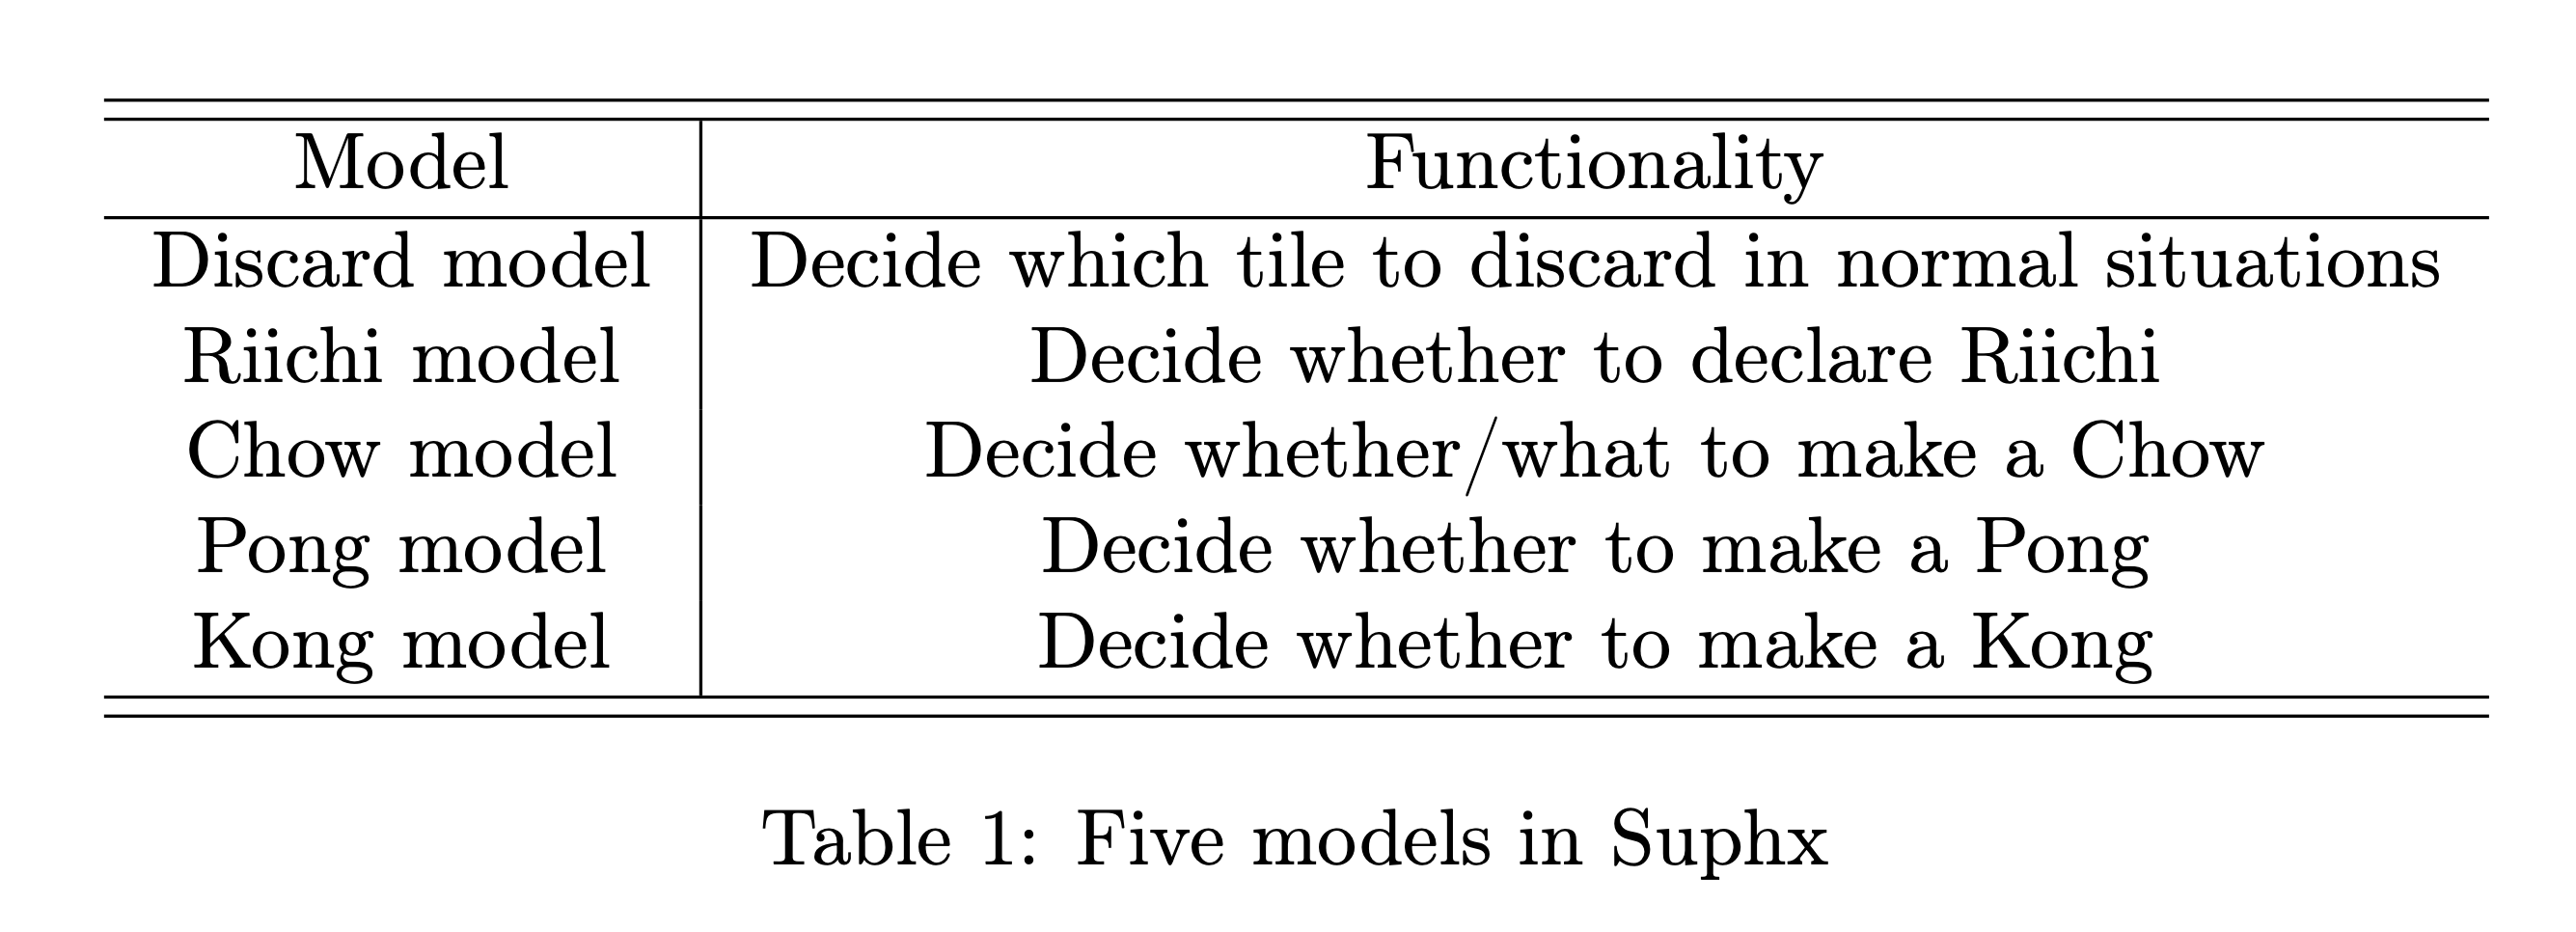

# TODO
1. Generate different target values based on the result needed
2. Store all the extracted data into a npz file
3. Deep learning model building & training
4. Estanlish the rule agent


DONE
1. Build a Mahjong class for storing stages
2. Add method in the class to take the stage and return the new board
3. Encode the pieces into the array
4. Encoder other useful features into the game



In [ ]:
import tensorflow as tf


model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()
model.compile(loss = 'categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)


# Game Engine

In [ ]:
# Implementation of the Mahjong class
class Game:
  def __init__(self):
    self.player = player

  def get_starting_tile(self, file_name, player_num):
    f = open(file_name, "r")
    title = f.readline()
    game_info = f.readline()

    for i in range(4):
      player_hand = f.readline()
      start = player_hand.find('[')
      end = player_hand.find(']') + 1
      starting_tile = ast.literal_eval(player_hand[start:end])
      if i == player_num:
        return starting_tile

  def next_turn(move):
    raise NotImplementedError

  def serialize(player):
    pass

class Player:
  def __init__(self, player_num, wind):
    self.player_num = player_num
    self.wind = wind
    self.tile = tile